In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import rosbag

import os

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

DEFAULT_FIG_SIZE = (10,10)
APT_ROOT_BAG_PATH = '/home/mitchell/magellan-data/MsftParkingLot/4-4-2020'

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [9]:
def extract_imu_dataframe(bag_path):
    bag = rosbag.Bag(bag_path, 'r')
    
    data_points = []
    first_point = True
    previous_time = 0
    for topic, msg, timestamp in bag.read_messages(topics=['/arduino_sensor_reader/output_topic_imu']):
        data_point = {}
        data_point['timestamp'] = timestamp.to_nsec()
        
        if (first_point):
            data_point['dt'] = 0
            first_point = False
        else:
            data_point['dt'] = data_point['timestamp'] - previous_time
        previous_time = data_point['timestamp']
        
        
        data_point['lin_x'] = msg.imu.linear_acceleration.x
        data_point['lin_y'] = msg.imu.linear_acceleration.y
        data_point['lin_z'] = msg.imu.linear_acceleration.z
        
        data_point['roll_vel'] = msg.imu.angular_velocity.x
        data_point['pitch_vel'] = msg.imu.angular_velocity.y
        data_point['yaw_vel'] = msg.imu.angular_velocity.z
        
        data_point['mag_x'] = msg.magnetometer.x
        data_point['mag_y'] = msg.magnetometer.y
        data_point['mag_z'] = msg.magnetometer.z
        
        data_point['temperature'] = msg.temperature
        
        data_points.append(data_point)
    
    columns = ['timestamp', 'dt', 'lin_x', 'lin_y', 'lin_z', 'roll_vel', 'pitch_vel', 'yaw_vel']
    columns += ['mag_x', 'mag_y', 'mag_z', 'temperature']
    return pd.DataFrame(data_points, columns=columns)

def extract_gps_dataframe(bag_path):
    bag = rosbag.Bag(bag_path, 'r')
    
    data_points = []
    first_point = True
    previous_time = 0
    for topic, msg, timestamp in bag.read_messages(topics=['/arduino_sensor_reader/output_topic_gps']):
        data_point = {}
        data_point['timestamp'] = timestamp.to_nsec()
        
        if (first_point):
            data_point['dt'] = 0
            first_point = False
        else:
            data_point['dt'] = data_point['timestamp'] - previous_time
        previous_time = data_point['timestamp']
        
        data_point['latitude'] = msg.latitude
        data_point['longitude'] = msg.longitude
        data_point['altitude'] = msg.altitude
        
        data_points.append(data_point)
    
    return pd.DataFrame(data_points, columns=['timestamp', 'dt', 'latitude', 'longitude', 'altitude'])
        
def extract_rosbags():
    file_header = 'five_minutes_'
    file_footer = '_noimage.bag'
    files = [f for f in os.listdir(APT_ROOT_BAG_PATH) if os.path.isfile(os.path.join(APT_ROOT_BAG_PATH, f))]
    files = [f for f in files if f.startswith(file_header) and f.endswith(file_footer)]
    
    output_imu = {}
    output_gps = {}
    for file in files:
        identifier = file.replace(file_header, '').replace(file_footer, '')
        file_path = os.path.join(APT_ROOT_BAG_PATH, file)
        output_imu[identifier] = extract_imu_dataframe(file_path)
        output_gps[identifier] = extract_gps_dataframe(file_path)
        
    output = {}
    output['imu'] = output_imu
    output['gps'] = output_gps
    
    return output

datasets = extract_rosbags()
datasets['gps']['east'].head()

,timestamp,dt,latitude,longitude,altitude
0,1584921778188084728,0,47.635887,122.129074,105.400002
1,1584921778368081816,179997088,47.635887,122.129074,105.400002
2,1584921778590009464,221927648,47.635887,122.129074,105.400002
3,1584921778770512216,180502752,47.635887,122.129074,105.400002
4,1584921778992809976,222297760,47.635887,122.129074,105.400002


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


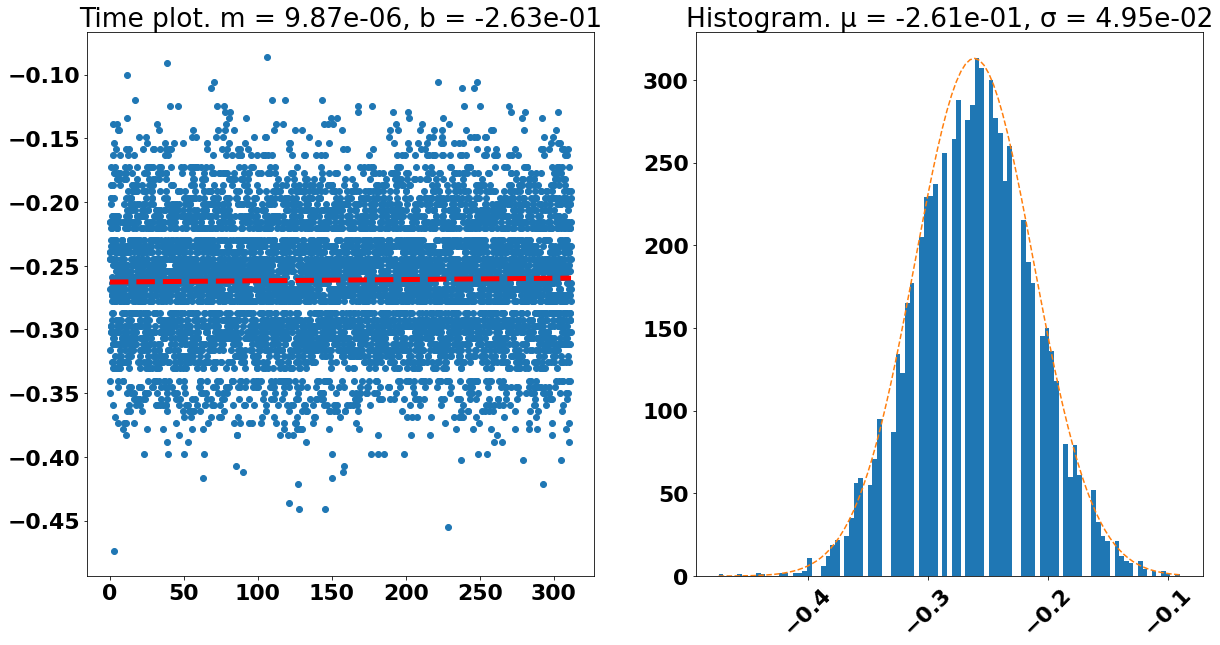

In [11]:
def histogram_and_time_plot(df, target_col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*DEFAULT_FIG_SIZE[0], DEFAULT_FIG_SIZE[1]))
    
    timestamps = (df['timestamp'] - np.min(df['timestamp'])) / (10 ** 9)
    data = df[target_col]
    
    coefficients = np.polyfit(timestamps, data, 1)
    line_of_best_fit = (timestamps * coefficients[0]) + coefficients[1]
    
    axes[0].scatter(timestamps, data, label=target_col)
    axes[0].plot(timestamps, line_of_best_fit, 'r--', linewidth=5)
    axes[0].set_title('Time plot. m = {0:.2e}, b = {1:.2e}'.format(coefficients[0], coefficients[1]))
    axes[0].ticklabel_format(useOffset=False, style='plain')
    
    num_bins = 100
    bins = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data)) / num_bins)
    
    mean = np.mean(data)
    stdev = np.std(data)
    
    hist_output = axes[1].hist(data, bins=bins, label='Measurements')
    fit_gaussian = np.max(np.abs(hist_output[0])) * np.exp(-0.5 * (((bins - mean) / stdev) ** 2))
    
    axes[1].set_title('Histogram. μ = {0:.2e}, σ = {1:.2e}'.format(mean, stdev))
    axes[1].plot(bins, fit_gaussian, '--')
    axes[1].ticklabel_format(useOffset=False, style='plain')
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(45)
    
    plt.show()
    
histogram_and_time_plot(datasets['imu']['east'], 'lin_x')

In [21]:
def make_comparison_chart(dfs, columns):
    samples = sorted([k for k in dfs.keys()])
    
    output_data_frame = []
    for column in columns:
        for sample in samples:
            row = {}
            row['column'] = column
            row['dataset'] = sample
            df = dfs[sample]

            timestamps = (df['timestamp'] - np.min(df['timestamp'])) / (10 ** 9)
            data = df[column]

            coefficients = np.polyfit(timestamps, data, 1)
            row['m'] = coefficients[0]
            row['b'] = coefficients[1]
            row['mean'] = np.mean(data)
            row['stdev'] = np.std(data)

            output_data_frame.append(row)
    
    return pd.DataFrame(output_data_frame, columns=['column', 'dataset', 'm', 'b', 'mean', 'stdev'])

columns = ['lin_x', 'lin_y', 'lin_z', 'roll_vel', 'pitch_vel', 'yaw_vel', 'mag_x', 'mag_y', 'mag_z', 'temperature']
comparison = make_comparison_chart(datasets['imu'], columns)
comparison

,column,dataset,m,b,mean,stdev
0,lin_x,east,9.867353e-06,-0.262752,-0.261214,0.049451
1,lin_x,north,-1.743038e-05,-0.250418,-0.253135,0.050206
2,lin_x,south,-5.966342e-05,-0.273573,-0.282870,0.051299
3,lin_x,west,-1.962544e-04,-0.301976,-0.332561,0.055643
4,lin_y,east,2.640024e-06,0.052810,0.053221,0.052446
5,lin_y,north,8.812992e-06,0.115554,0.116927,0.053370
6,lin_y,south,9.019083e-06,0.084008,0.085413,0.052865
7,lin_y,west,4.415065e-06,0.154844,0.155532,0.053286
8,lin_z,east,6.684378e-06,9.703264,9.704306,0.083321
9,lin_z,north,9.836598e-07,9.731942,9.732095,0.088292


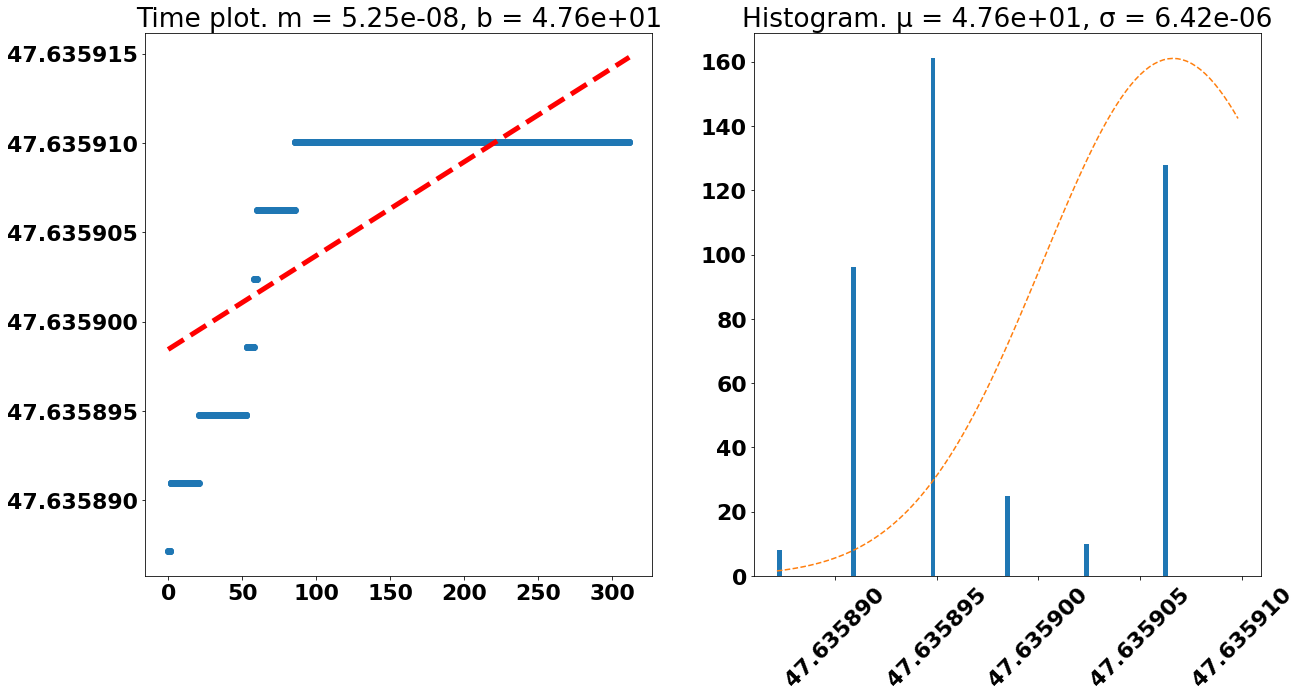

In [20]:
histogram_and_time_plot(datasets['gps']['east'], 'latitude')

In [22]:
columns = ['latitude', 'longitude', 'altitude']
comparison = make_comparison_chart(datasets['gps'], columns)
comparison

,column,dataset,m,b,mean,stdev
0,latitude,east,5.250319e-08,47.635898,47.635907,0.000006
1,latitude,north,-1.439382e-07,47.635953,47.635931,0.000016
2,latitude,south,1.758256e-07,47.635863,47.635890,0.000018
3,latitude,west,1.107429e-07,47.635879,47.635897,0.000013
4,longitude,east,-6.251758e-08,122.129076,122.129066,0.000007
5,longitude,north,-5.460323e-08,122.129031,122.129023,0.000008
6,longitude,south,1.068117e-07,122.129013,122.129030,0.000015
7,longitude,west,-1.044141e-07,122.129015,122.128999,0.000011
8,altitude,east,1.519457e-02,106.658387,109.024134,1.862871
9,altitude,north,-1.351707e-03,117.970076,117.759461,0.434924


In [27]:
def compute_covariance_matrix(datasets, x_series_name, y_series_name, z_series_name):
    samples = sorted([k for k in datasets.keys()])
    series_names = [x_series_name, y_series_name, z_series_name]
    
    covariance_matricies = np.zeros(shape=(3, 3, len(samples)), dtype=np.float)
    for i in range(0, len(samples), 1):
        selected_df = datasets[samples[i]][series_names]
        covariance_matrix = selected_df.cov()
        covariance_matricies[:, :, i] = covariance_matrix
        
    # TODO: is this the proper aggregation method?
    final_covariance_matrix = np.mean(covariance_matricies, axis=2)
    return final_covariance_matrix
        
covariance_matrix = compute_covariance_matrix(datasets['imu'], 'lin_x', 'lin_y', 'lin_z')
print(covariance_matrix)

[[ 0.00267385 -0.00027857 -0.00032208]
 [-0.00027857  0.00280865  0.00068291]
 [-0.00032208  0.00068291  0.00735696]]


In [32]:
def write_matrix_to_file(fp, matrix_name, matrix_value):
    fp.write('{0}\n'.format(matrix_name))
    fp.write('{0} {1}\n'.format(matrix_value.shape[0], matrix_value.shape[1]))
    for y in range(0, matrix_value.shape[0], 1):
        for x in range(0, matrix_value.shape[1] - 1, 1):
            fp.write('{0} '.format(matrix_value[y][x]))
        fp.write('{0}\n'.format(matrix_value[y][matrix_value.shape[1]-1]))

def write_real_to_file(fp, real_name, real_value):
    fp.write('{0}\n'.format(real_name))
    fp.write('{0}\n'.format(real_value))

def write_kf_config(output_file_path, datasets):
    state_dimension = 15
    imu_accel_cov_matrix = compute_covariance_matrix(datasets['imu'], 'lin_x', 'lin_y', 'lin_z')
    imu_heading_cov_matrix = compute_covariance_matrix(datasets['imu'], 'mag_x', 'mag_y', 'mag_z')
    imu_ang_vel_cov_matrix = compute_covariance_matrix(datasets['imu'], 'roll_vel', 'pitch_vel', 'yaw_vel')
    
    gps_pose_cov_matrix = compute_covariance_matrix(datasets['gps'], 'latitude', 'longitude', 'altitude')
    
    base_forward_matrix = np.zeros(shape=(state_dimension, 1))
    base_forward_covariance_matrix = np.zeros(shape=(state_dimension, state_dimension))
    base_turn_matrix = np.zeros(shape=(state_dimension, 1))
    base_turn_covariance_matrix = np.zeros(shape=(state_dimension, state_dimension))
    
    # Emperically measured forward velocity. At 35/40, => 74" / 5 seconds. Converted to m/s
    # Robot drifted a bit to the right, about 2" / 5 seconds. Converted to m/s
    # Robot drifted a bit to the right, about 2 degrees / 5 seconds. Converted to rad / sec
    base_forward_matrix[3] = 0.37592
    base_forward_matrix[4] = 0.01016
    base_forward_matrix[14] = 0.00698132
    
    # Set standard deviation among all axes to 0.5 in / 5 seconds
    # Set standard deviation in z axis rotation to 0.57 in / 5 seconds
    base_forward_covariance_matrix[3:6, 3:6] = np.eye(3) * 0.00254
    base_forward_covariance_matrix[14, 14] = 0.0019896754
    
    # Emperically measured turn velocity. At -35/40, => 190 degrees / 3 seconds. Converted to rad / sec
    # Robot mostly stayed in place. 
    base_turn_matrix[14] = -1.10537666667
    
    # Set standard deviation in angular rotation to 1 degree / 3 seconds. Converted to rad / sec
    # Set motion standard deviation to 1 inch / 3 seconds. This is on the conservative side.
    base_turn_covariance_matrix[12:15, 12:15] = np.eye(3) * 0.00581776666 
    base_turn_covariance_matrix[3:6, 3:6] = np.eye(3) * 0.00846666666
    
    base_speed = 40
    left_power_multiplier = 40/35
    
    with open(output_file_path, 'w') as fp:
        write_matrix_to_file(fp, 'imu_local_acceleration_covariance', imu_accel_cov_matrix)
        write_matrix_to_file(fp, 'imu_global_heading_covariance', imu_heading_cov_matrix)
        write_matrix_to_file(fp, 'imu_local_angular_velocity_covariance', imu_ang_vel_cov_matrix)
        
        write_matrix_to_file(fp, 'gps_covariance', gps_pose_cov_matrix)
        
        write_matrix_to_file(fp, 'base_forward_matrix', base_forward_matrix)
        write_matrix_to_file(fp, 'base_forward_covariance_matrix', base_forward_covariance_matrix)
        write_matrix_to_file(fp, 'base_turn_matrix', base_turn_matrix)
        write_matrix_to_file(fp, 'base_turn_covariance_matrix', base_turn_covariance_matrix)
        write_real_to_file(fp, 'base_speed', base_speed)
        write_real_to_file(fp, 'left_power_multiplier', left_power_multiplier)
        
write_kf_config('linear_kf_config.config', datasets)    